## Install and Imports

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

!pip install -q medmnist transformers tf-keras

import medmnist
from medmnist import INFO
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras import layers, models, applications, mixed_precision
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from transformers import TFViTForImageClassification, TFSwinForImageClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, log_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.9 MB/s eta 0:00:00


2026-02-12 10:52:26.282417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770893546.683137      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770893546.816342      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770893547.673981      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770893547.674021      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770893547.674024      55 computation_placer.cc:177] computation placer alr

In [2]:
print(f"Legacy Keras Enabled: {str(os.environ.get('TF_USE_LEGACY_KERAS'))}")

Legacy Keras Enabled: 1


In [3]:
# CONFIGURATION 
DATASET = 'bloodmnist'
BATCH_SIZE = 8 
EPOCHS = 30

In [4]:
# MIXED PRECISION SETUP 
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f"Policy: {policy.name} | Compute: {policy.compute_dtype}")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Policy: mixed_float16 | Compute: float16


## Data Loader Function

In [5]:
# Function: Data Loader
def load_medmnist_data(dataset_flag, size=224, batch_size=8):
    info = INFO[dataset_flag]
    n_classes = len(info['label'])
    DataClass = getattr(medmnist, info['python_class'])

    print(f"Loading {dataset_flag}...")
    train_data = DataClass(split='train', download=True, size=size)
    val_data = DataClass(split='val', download=True, size=size)
    test_data = DataClass(split='test', download=True, size=size)

    X_train, y_train = train_data.imgs, train_data.labels
    X_val, y_val = val_data.imgs, val_data.labels
    X_test, y_test = test_data.imgs, test_data.labels

    if X_train.shape[-1] != 3:
        X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
        X_val = np.repeat(X_val[..., np.newaxis], 3, -1)
        X_test = np.repeat(X_test[..., np.newaxis], 3, -1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_test = X_test.astype('float32')

    y_train_enc = to_categorical(y_train, n_classes)
    y_val_enc = to_categorical(y_val, n_classes)
    y_test_enc = to_categorical(y_test, n_classes)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))\
        .shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_enc)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc)).batch(batch_size)

    return train_ds, val_ds, test_ds, n_classes, y_test, X_test

## Model Loader Function

In [6]:
# Function: Model Loader 
def get_model(model_name, n_classes, input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)
    
    if model_name == 'EfficientNetV2M':
        base = applications.EfficientNetV2M(include_top=False, weights='imagenet', input_tensor=inputs)
        x = layers.GlobalAveragePooling2D()(base.output)
        # Force float32 for stability in final layer
        outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
        return models.Model(inputs=inputs, outputs=outputs, name=model_name)

    elif model_name == 'InceptionResNetV2':
        x = layers.Rescaling(1./127.5, offset=-1)(inputs)
        base = applications.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=x)
        x = layers.GlobalAveragePooling2D()(base.output)
        outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
        return models.Model(inputs=inputs, outputs=outputs, name=model_name)

    elif model_name == 'ConvNeXtBase':
        base = applications.ConvNeXtBase(include_top=False, weights='imagenet', input_tensor=inputs)
        x = layers.GlobalAveragePooling2D()(base.output)
        outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
        return models.Model(inputs=inputs, outputs=outputs, name=model_name)

    elif model_name == 'ViT-Base':
        x = layers.Rescaling(1./127.5, offset=-1)(inputs)
        x = layers.Permute((3, 1, 2))(x)
        backbone = TFViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224', num_labels=n_classes, 
            ignore_mismatched_sizes=True, use_safetensors=False)
        outputs = backbone.vit(x)[0]
        outputs = backbone.classifier(outputs[:, 0, :])
        outputs = layers.Activation('softmax', dtype='float32')(outputs)
        return models.Model(inputs=inputs, outputs=outputs, name=model_name)

    else:
        raise ValueError("Unknown Model")


## Trainer Function

In [7]:
# Function: Model Trainer
def train_and_save(model_name):
    print(f"\n{'='*20} TRAINING {model_name} {'='*20}")
    tf.keras.backend.clear_session()
    gc.collect()
    
    if os.path.exists(f"{model_name}_{DATASET}.keras"):
        print(f"Found existing model: {model_name}_{DATASET}.keras. Loading weights...")
        model = get_model(model_name, n_classes)
        model.load_weights(f"{model_name}_{DATASET}.keras")
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        # Train from scratch
        model = get_model(model_name, n_classes)
        lr = 2e-5 if model_name in ['ViT-Base'] else 1e-4
        model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
                      loss='categorical_crossentropy', metrics=['accuracy'])
        
        callbacks = [
            ModelCheckpoint(f"{model_name}_{DATASET}.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
        ]
        model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)
        # Load best weights
        model.load_weights(f"{model_name}_{DATASET}.keras")

    # Generate Predictions
    print(f"Generating predictions for {model_name}...")
    
    # Validation Set
    val_preds = model.predict(val_ds)
    np.save(f"{model_name}_val_preds.npy", val_preds)
    
    # Test Set
    test_preds = model.predict(test_ds)
    np.save(f"{model_name}_preds.npy", test_preds)
    
    # Test Accuracy
    acc = accuracy_score(y_true_flat, np.argmax(test_preds, axis=1))
    print(f"{model_name} Test Accuracy: {acc:.4f}")
    
    del model
    gc.collect()
    return acc

In [8]:
# LOAD DATA
train_ds, val_ds, test_ds, n_classes, y_test_true, X_test_raw = load_medmnist_data(DATASET, batch_size=BATCH_SIZE)
y_true_flat = y_test_true.flatten()
y_true_cat = to_categorical(y_true_flat, n_classes)
print(f"Data Ready. Classes: {n_classes}")

Loading bloodmnist...


100%|██████████| 1.54G/1.54G [00:14<00:00, 105MB/s] 
I0000 00:00:1770893615.549189      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Data Ready. Classes: 8


## Training

In [9]:
train_and_save('ViT-Base')


==================== TRAINING ViT-Base ====================


config.json: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/347M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFViTForImageClassification.

Some weights of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier/kernel:0: found shape (768, 1000) in the checkpoint and (768, 8) in the model instantiated
- classifier/bias:0: found shape (1000,) in the checkpoint and (8,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30


I0000 00:00:1770893677.409033     126 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1770893680.115231     128 service.cc:152] XLA service 0x7b8734013410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770893680.115264     128 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770893680.712671     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1495/1495 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9601
Epoch 1: val_accuracy improved from -inf to 0.98657, saving model to ViT-Base_bloodmnist.keras
1495/1495 [==============================] - 413s 247ms/step - loss: 0.1351 - accuracy: 0.9601 - val_loss: 0.0371 - val_accuracy: 0.9866 - lr: 2.0000e-05
Epoch 2/30
1495/1495 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9904
Epoch 2: val_accuracy did not improve from 0.98657
1495/1495 [==============================] - 360s 241ms/step - loss: 0.0306 - accuracy: 0.9904 - val_loss: 0.0476 - val_accuracy: 0.9848 - lr: 2.0000e-05
Epoch 3/30
1495/1495 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9939
Epoch 3: val_accuracy did not improve from 0.98657
1495/1495 [==============================] - 359s 240ms/step - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.0569 - val_accuracy: 0.9831 - lr: 2.0000e-05
Epoch 4/30
1495/1495 [==============================] - ET

0.9915229465068693

In [10]:
train_and_save('ConvNeXtBase')


==================== TRAINING ConvNeXtBase ====================
350926856/350926856 [==============================] - 9s 0us/step
Epoch 1/30


2026-02-12 12:21:29.758242: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 12:21:29.942252: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 12:21:30.210134: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 12:21:30.417409: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1494/1495 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9565

2026-02-12 12:30:05.155875: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 12:30:05.339817: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 12:30:05.578618: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 12:30:05.785387: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1495/1495 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9565
Epoch 1: val_accuracy improved from -inf to 0.98715, saving model to ConvNeXtBase_bloodmnist.keras
1495/1495 [==============================] - 700s 385ms/step - loss: 0.1387 - accuracy: 0.9565 - val_loss: 0.0446 - val_accuracy: 0.9871 - lr: 1.0000e-04
Epoch 2/30
1495/1495 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9836
Epoch 2: val_accuracy did not improve from 0.98715
1495/1495 [==============================] - 437s 292ms/step - loss: 0.0508 - accuracy: 0.9836 - val_loss: 0.0586 - val_accuracy: 0.9819 - lr: 1.0000e-04
Epoch 3/30
1495/1495 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9896
Epoch 3: val_accuracy improved from 0.98715 to 0.99124, saving model to ConvNeXtBase_bloodmnist.keras
1495/1495 [==============================] - 444s 297ms/step - loss: 0.0341 - accuracy: 0.9896 - val_loss: 0.0330 - val_accuracy: 0.9912 - lr: 1.0000e-04
Epo

0.9929845074539608

In [11]:
train_and_save('EfficientNetV2M')


==================== TRAINING EfficientNetV2M ====================
214201816/214201816 [==============================] - 6s 0us/step
Epoch 1/30


E0000 00:00:1770906652.611912      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2M/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1495/1495 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9342
Epoch 1: val_accuracy improved from -inf to 0.95853, saving model to EfficientNetV2M_bloodmnist.keras
1495/1495 [==============================] - 669s 326ms/step - loss: 0.2123 - accuracy: 0.9342 - val_loss: 0.1312 - val_accuracy: 0.9585 - lr: 1.0000e-04
Epoch 2/30
1495/1495 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9776
Epoch 2: val_accuracy improved from 0.95853 to 0.98306, saving model to EfficientNetV2M_bloodmnist.keras
1495/1495 [==============================] - 460s 308ms/step - loss: 0.0775 - accuracy: 0.9776 - val_loss: 0.0514 - val_accuracy: 0.9831 - lr: 1.0000e-04
Epoch 3/30
1495/1495 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9830
Epoch 3: val_accuracy did not improve from 0.98306
1495/1495 [==============================] - 455s 304ms/step - loss: 0.0530 - accuracy: 0.9830 - val_loss: 0.0752 - val_accuracy: 0.9755 - lr: 1.0000e-

0.9894767611809413

In [12]:
train_and_save('InceptionResNetV2')


==================== TRAINING InceptionResNetV2 ====================
219055592/219055592 [==============================] - 6s 0us/step
Epoch 1/30
1495/1495 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.9416
Epoch 1: val_accuracy improved from -inf to 0.95561, saving model to InceptionResNetV2_bloodmnist.keras
1495/1495 [==============================] - 432s 206ms/step - loss: 0.1790 - accuracy: 0.9416 - val_loss: nan - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 2/30
1495/1495 [==============================] - ETA: 0s - loss: 0.0558 - accuracy: 0.9824
Epoch 2: val_accuracy improved from 0.95561 to 0.96846, saving model to InceptionResNetV2_bloodmnist.keras
1495/1495 [==============================] - 268s 179ms/step - loss: 0.0558 - accuracy: 0.9824 - val_loss: 0.2756 - val_accuracy: 0.9685 - lr: 1.0000e-04
Epoch 3/30
1495/1495 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9877
Epoch 3: val_accuracy did not improve from 0.96846
14

0.9883075124232681

## Ensemble (Soft Voting) & Results


ENSEMBLE EXECUTION
Loading ConvNeXtBase_preds.npy...
Loading ViT-Base_preds.npy...
Loading EfficientNetV2M_preds.npy...
Loading InceptionResNetV2_preds.npy...

>>> Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      1.00      1.00       624
           2       1.00      0.99      1.00       311
           3       0.98      0.99      0.98       579
           4       1.00      1.00      1.00       243
           5       1.00      0.99      0.99       284
           6       0.99      0.98      0.99       666
           7       1.00      1.00      1.00       470

    accuracy                           0.99      3421
   macro avg       0.99      0.99      0.99      3421
weighted avg       0.99      0.99      0.99      3421

Ensemble Accuracy: 0.9930
Ensemble AUC:      0.9996


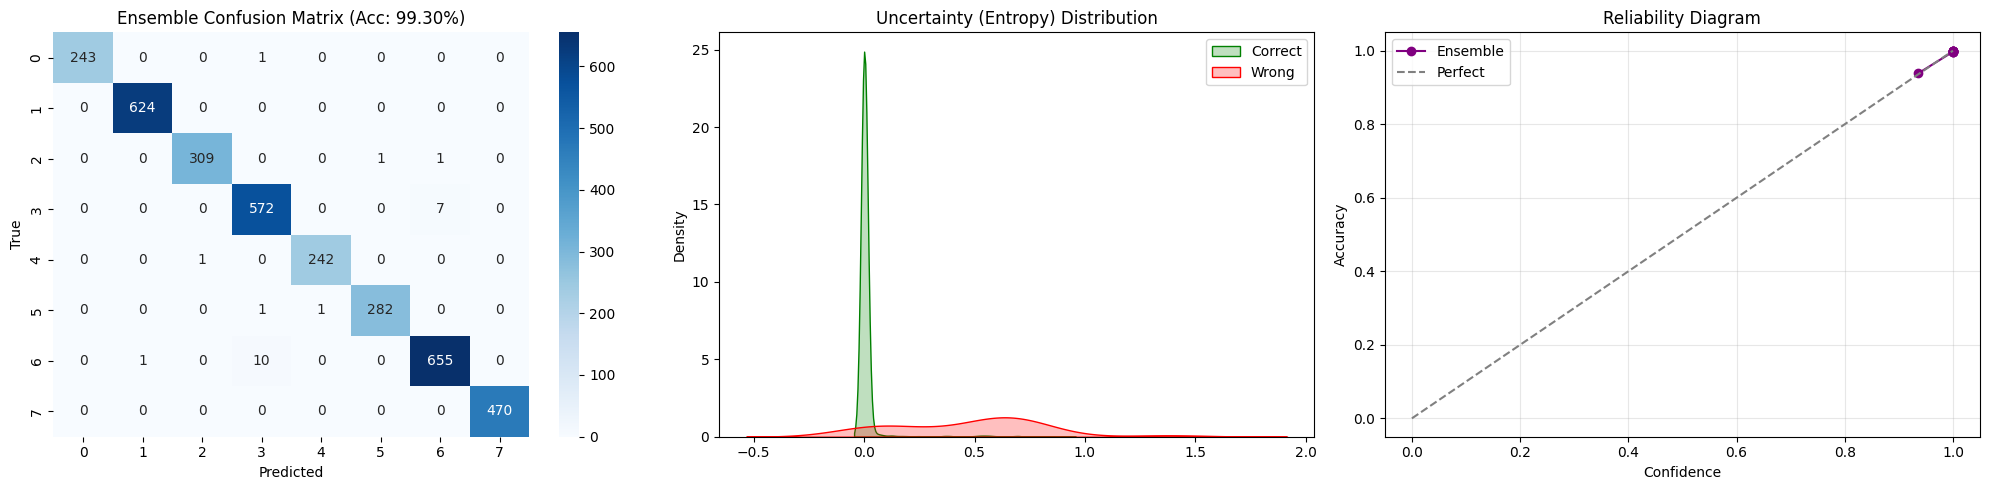

In [13]:
# ENSEMBLE ANALYSIS 
print(f"\n{'='*30}\nENSEMBLE EXECUTION\n{'='*30}")

MODELS_TO_LOAD = ['ConvNeXtBase', 'ViT-Base', 'EfficientNetV2M', 'InceptionResNetV2']
loaded_preds = []
valid_models = []

for m in MODELS_TO_LOAD:
    filename = f"{m}_preds.npy"
    if os.path.exists(filename):
        print(f"Loading {filename}...")
        loaded_preds.append(np.load(filename))
        valid_models.append(m)
    else:
        print(f"Warning: {filename} not found. Skipping.")

if not loaded_preds:
    raise ValueError("No predictions found! Train at least one model first.")

# Stack and Average
all_preds = np.array(loaded_preds) # Shape: (Num_Models, N_Samples, N_Classes)
ensemble_probs = np.mean(all_preds, axis=0)

y_pred_ensemble = np.argmax(ensemble_probs, axis=1)

# Metrics
print("\n>>> Classification Report:")
print(classification_report(y_true_flat, y_pred_ensemble))

ens_acc = accuracy_score(y_true_flat, y_pred_ensemble)
ens_auc = roc_auc_score(y_true_cat, ensemble_probs, multi_class='ovr')
ens_loss = log_loss(y_true_cat, ensemble_probs)

print(f"Ensemble Accuracy: {ens_acc:.4f}")
print(f"Ensemble AUC:      {ens_auc:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Confusion Matrix
cm = confusion_matrix(y_true_flat, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Ensemble Confusion Matrix (Acc: {ens_acc:.2%})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Uncertainty (Entropy)
entropy = -np.sum(ensemble_probs * np.log(ensemble_probs + 1e-9), axis=1)
correct_mask = (y_pred_ensemble == y_true_flat)

sns.kdeplot(entropy[correct_mask], label='Correct', fill=True, color='green', ax=axes[1])
sns.kdeplot(entropy[~correct_mask], label='Wrong', fill=True, color='red', ax=axes[1])
axes[1].set_title('Uncertainty (Entropy) Distribution')
axes[1].legend()

# Calibration (Top-Class)
is_correct = (y_pred_ensemble == y_true_flat).astype(int)
pred_confidence = np.max(ensemble_probs, axis=1)
prob_true, prob_pred = calibration_curve(is_correct, pred_confidence, n_bins=10, strategy='quantile')

axes[2].plot(prob_pred, prob_true, marker='o', label='Ensemble', color='purple')
axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect')
axes[2].set_title('Reliability Diagram')
axes[2].set_xlabel('Confidence')
axes[2].set_ylabel('Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Individual Model Results


INDIVIDUAL MODEL DIAGNOSTICS

==================== ConvNeXtBase ====================
Accuracy: 99.2985%
AUC:      0.9995
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      1.00      1.00       624
           2       0.99      1.00      1.00       311
           3       0.98      0.99      0.98       579
           4       0.99      0.99      0.99       243
           5       0.99      0.99      0.99       284
           6       0.99      0.99      0.99       666
           7       1.00      1.00      1.00       470

    accuracy                           0.99      3421
   macro avg       0.99      0.99      0.99      3421
weighted avg       0.99      0.99      0.99      3421



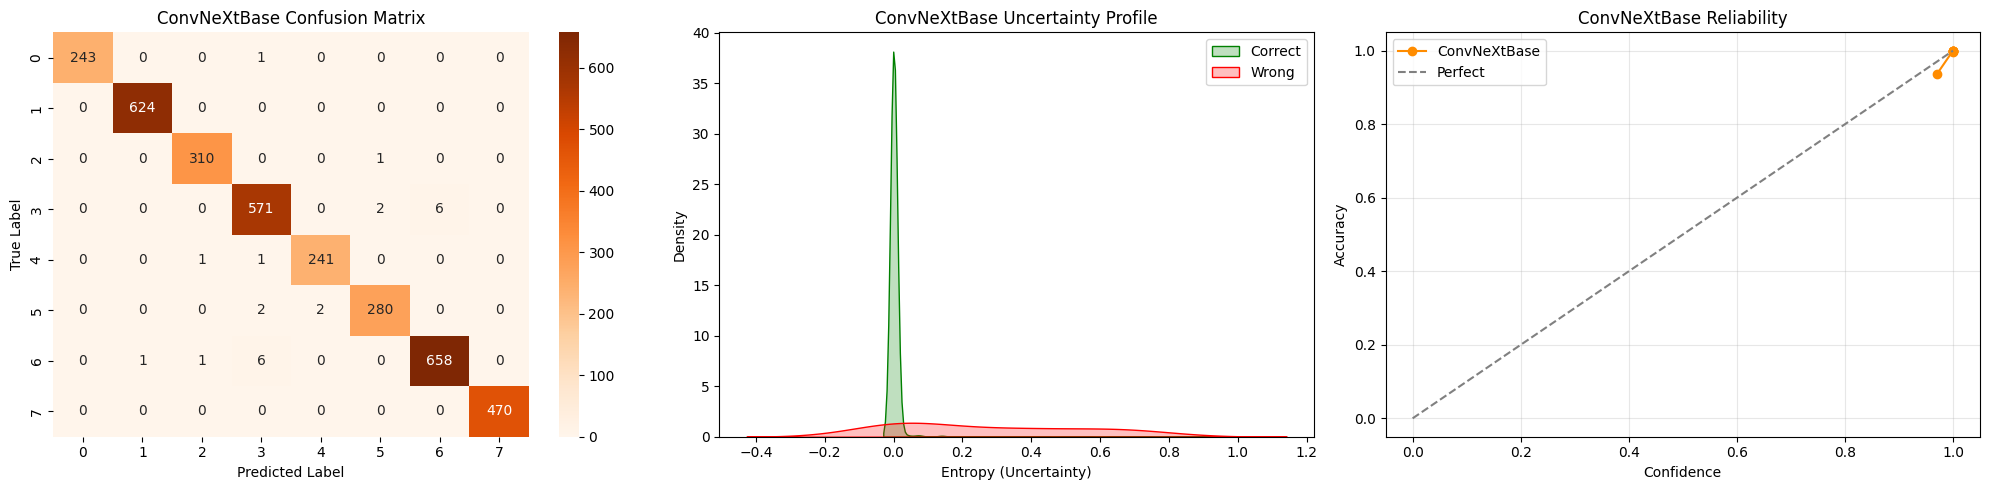


==================== ViT-Base ====================
Accuracy: 99.1523%
AUC:      0.9994
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      1.00      1.00       624
           2       0.99      1.00      0.99       311
           3       0.98      0.98      0.98       579
           4       0.99      0.99      0.99       243
           5       0.99      0.99      0.99       284
           6       0.99      0.98      0.99       666
           7       1.00      1.00      1.00       470

    accuracy                           0.99      3421
   macro avg       0.99      0.99      0.99      3421
weighted avg       0.99      0.99      0.99      3421



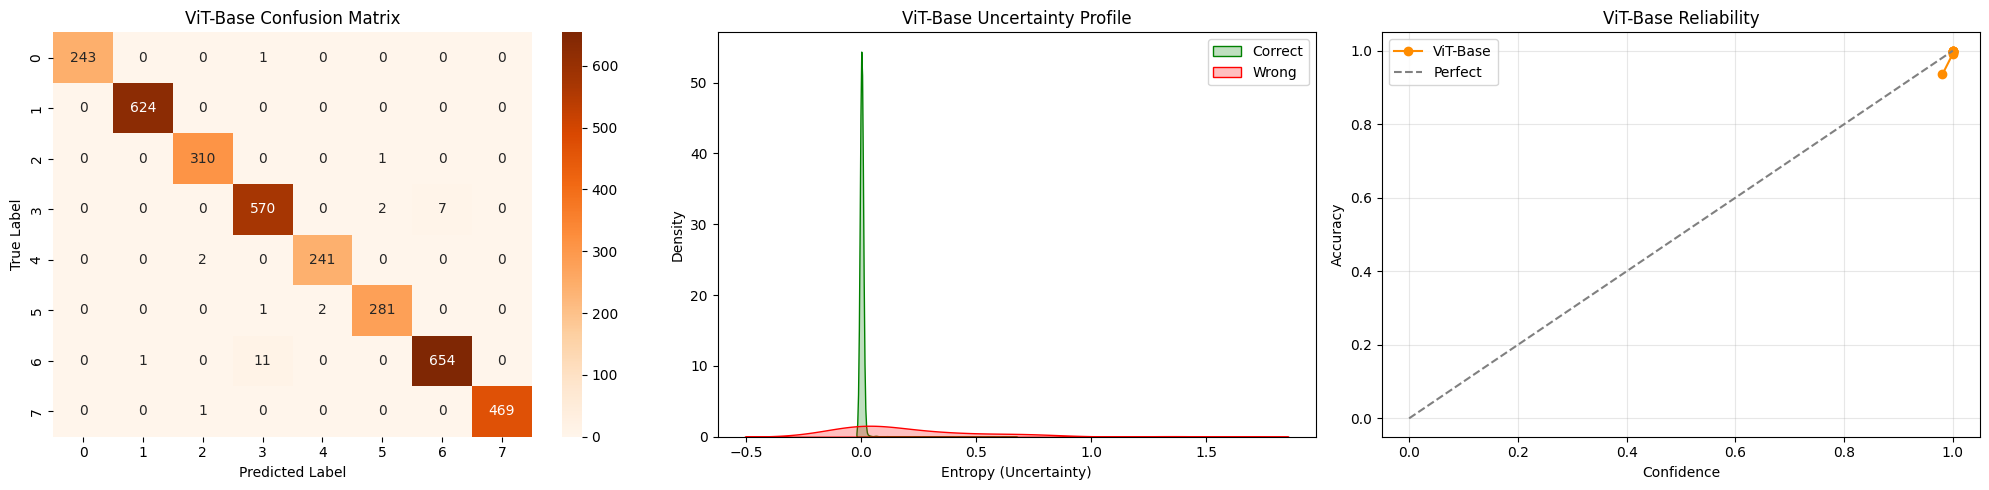


==================== EfficientNetV2M ====================
Accuracy: 98.9477%
AUC:      0.9992
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       244
           1       1.00      1.00      1.00       624
           2       1.00      0.99      1.00       311
           3       0.97      0.98      0.98       579
           4       0.99      0.99      0.99       243
           5       0.99      0.99      0.99       284
           6       0.98      0.97      0.98       666
           7       1.00      1.00      1.00       470

    accuracy                           0.99      3421
   macro avg       0.99      0.99      0.99      3421
weighted avg       0.99      0.99      0.99      3421



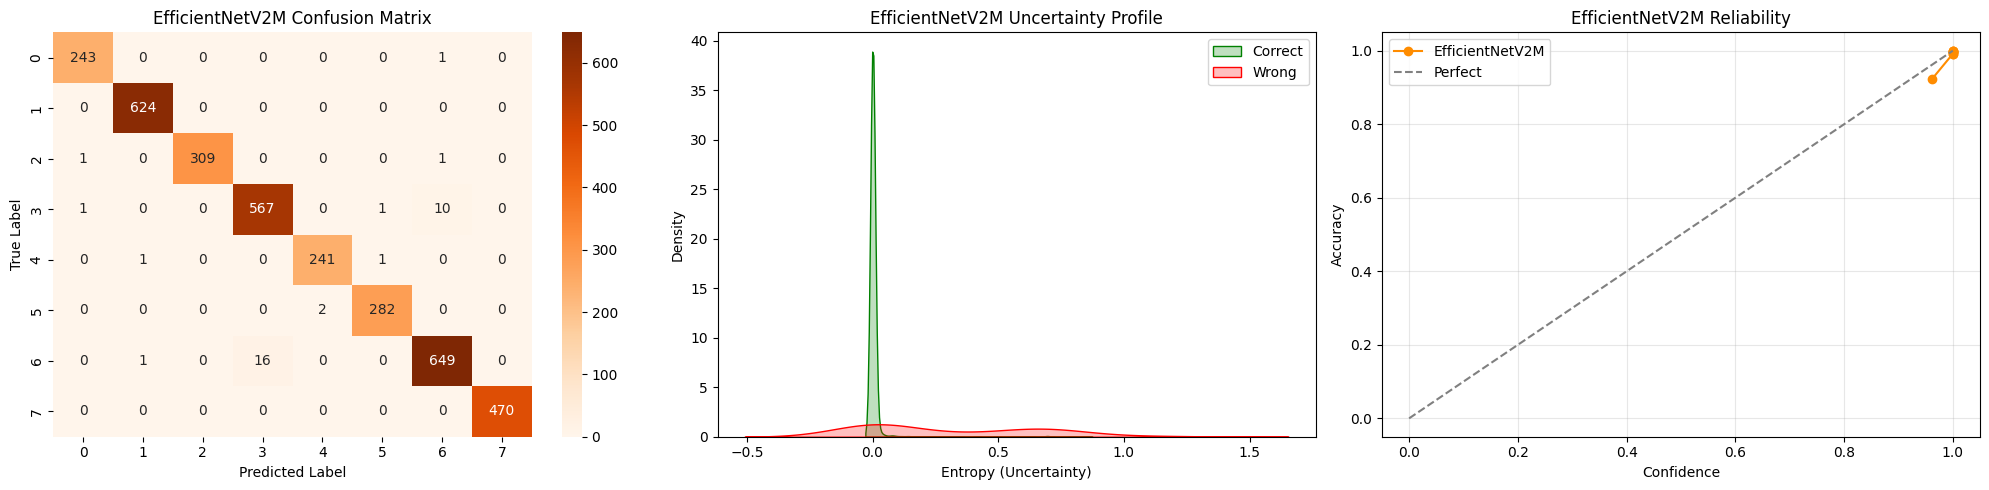


==================== InceptionResNetV2 ====================
Accuracy: 98.8308%
AUC:      0.9997
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       244
           1       1.00      1.00      1.00       624
           2       1.00      0.99      0.99       311
           3       0.97      0.98      0.98       579
           4       0.98      1.00      0.99       243
           5       0.99      0.98      0.98       284
           6       0.98      0.97      0.98       666
           7       1.00      1.00      1.00       470

    accuracy                           0.99      3421
   macro avg       0.99      0.99      0.99      3421
weighted avg       0.99      0.99      0.99      3421



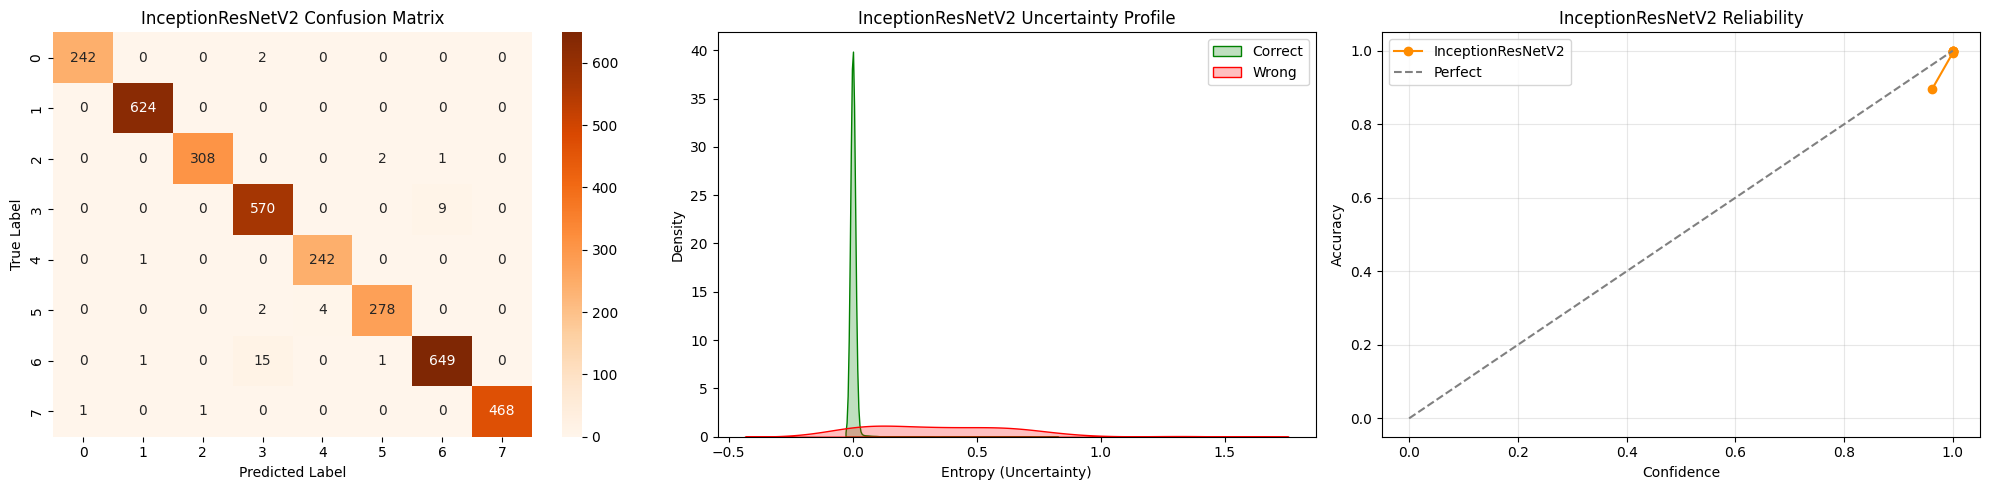


FINAL PERFORMANCE SUMMARY
Model Name           | Accuracy  
-----------------------------------
ConvNeXtBase         | 99.2985%
ViT-Base             | 99.1523%
EfficientNetV2M      | 98.9477%
InceptionResNetV2    | 98.8308%
-----------------------------------


In [14]:
MODELS_TO_LOAD = ['ConvNeXtBase', 'ViT-Base', 'EfficientNetV2M', 'InceptionResNetV2']

print(f"\n{'='*50}\nINDIVIDUAL MODEL DIAGNOSTICS\n{'='*50}")

model_scores = {}

for model_name in MODELS_TO_LOAD:
    filename = f"{model_name}_preds.npy"
    
    if not os.path.exists(filename):
        print(f"Warning: {filename} not found. Skipping.")
        continue

    # Load Predictions
    preds_probs = np.load(filename)
    y_pred = np.argmax(preds_probs, axis=1)

    # Calculate Metrics
    acc = accuracy_score(y_true_flat, y_pred)
    auc = roc_auc_score(y_true_cat, preds_probs, multi_class='ovr')
    model_scores[model_name] = acc

    print(f"\n{'='*20} {model_name} {'='*20}")
    print(f"Accuracy: {acc:.4%}")
    print(f"AUC:      {auc:.4f}")
    print("-" * 60)
    print(classification_report(y_true_flat, y_pred))

    # Plotting Suite
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Confusion Matrix
    cm = confusion_matrix(y_true_flat, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0])
    axes[0].set_title(f'{model_name} Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Uncertainty (Entropy) Distribution
    entropy = -np.sum(preds_probs * np.log(preds_probs + 1e-9), axis=1)
    correct_mask = (y_pred == y_true_flat)
    
    sns.kdeplot(entropy[correct_mask], label='Correct', fill=True, color='green', ax=axes[1])
    sns.kdeplot(entropy[~correct_mask], label='Wrong', fill=True, color='red', ax=axes[1])
    axes[1].set_title(f'{model_name} Uncertainty Profile')
    axes[1].set_xlabel('Entropy (Uncertainty)')
    axes[1].legend()

    # Reliability Diagram (Calibration)
    is_correct = (y_pred == y_true_flat).astype(int)
    pred_conf = np.max(preds_probs, axis=1)
    prob_true, prob_pred = calibration_curve(is_correct, pred_conf, n_bins=10, strategy='quantile')
    
    axes[2].plot(prob_pred, prob_true, marker='o', label=model_name, color='darkorange')
    axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect')
    axes[2].set_title(f'{model_name} Reliability')
    axes[2].set_xlabel('Confidence')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Summary Comparison Table
print("\n" + "="*30)
print("FINAL PERFORMANCE SUMMARY")
print("="*30)
print(f"{'Model Name':<20} | {'Accuracy':<10}")
print("-" * 35)
for name, score in model_scores.items():
    print(f"{name:<20} | {score:.4%}")
print("-" * 35)

## Stacking & Results


RIGOROUS STACKING (No Data Leakage)
Loading VALIDATION predictions (Meta-Train)...
Meta-Train Input Shape: (1712, 32)
Loading TEST predictions (Meta-Eval)...
Meta-Test Input Shape:  (3421, 32)

Training Meta-Learner on Validation Set...
Epoch 1/50
97/97 [==============================] - 2s 5ms/step - loss: 1.3159 - accuracy: 0.7279 - val_loss: 0.3650 - val_accuracy: 0.9942
Epoch 2/50
97/97 [==============================] - 0s 4ms/step - loss: 0.2672 - accuracy: 0.9857 - val_loss: 0.0521 - val_accuracy: 0.9942
Epoch 3/50
97/97 [==============================] - 0s 3ms/step - loss: 0.1018 - accuracy: 0.9922 - val_loss: 0.0348 - val_accuracy: 0.9942
Epoch 4/50
97/97 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.9929 - val_loss: 0.0387 - val_accuracy: 0.9942
Epoch 5/50
97/97 [==============================] - 0s 3ms/step - loss: 0.0556 - accuracy: 0.9942 - val_loss: 0.0410 - val_accuracy: 0.9942
Epoch 6/50
97/97 [==============================] - 0s 3ms/ste

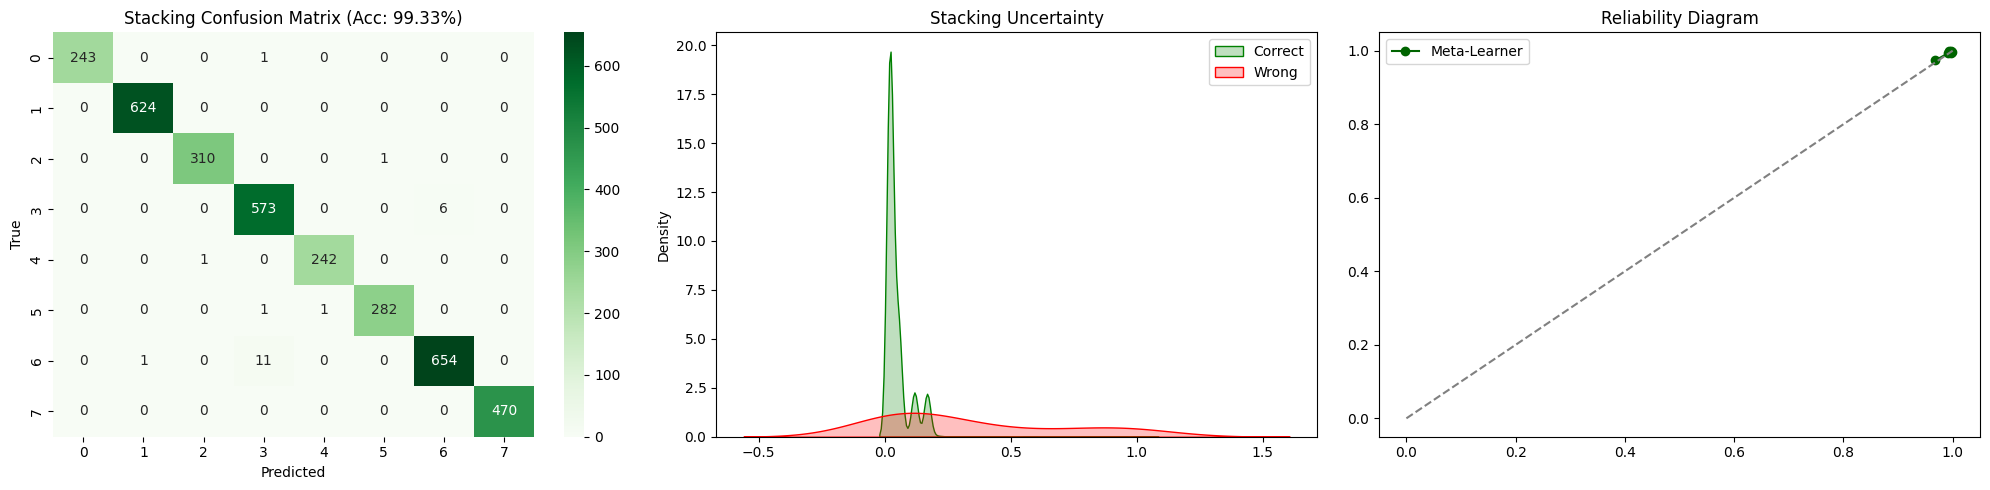

In [15]:
from tensorflow.keras import  callbacks 

print(f"\n{'='*30}\nRIGOROUS STACKING (No Data Leakage)\n{'='*30}")
MODELS_TO_LOAD = ['ConvNeXtBase', 'ViT-Base', 'EfficientNetV2M', 'InceptionResNetV2']

# training meta-data  (From Validation Set)
print("Loading VALIDATION predictions (Meta-Train)...")
val_preds_list = []
for m in MODELS_TO_LOAD:
    filename = f"{m}_val_preds.npy"
    if os.path.exists(filename):
        val_preds_list.append(np.load(filename))
    else:
        raise ValueError(f"Missing validation preds for {m}. Re-run training cell.")

X_meta_train = np.concatenate(val_preds_list, axis=1) # (N_Val, 32)

# labels for the validation set
y_val_true = np.concatenate([y for x, y in val_ds], axis=0)
y_val_flat = np.argmax(y_val_true, axis=1)

print(f"Meta-Train Input Shape: {X_meta_train.shape}")


# testing meta-data (From Test Set) 
print("Loading TEST predictions (Meta-Eval)...")
test_preds_list = []
for m in MODELS_TO_LOAD:
    filename = f"{m}_preds.npy"
    if os.path.exists(filename):
        test_preds_list.append(np.load(filename))
    else:
        raise ValueError(f"Missing test preds for {m}.")

X_meta_test = np.concatenate(test_preds_list, axis=1) # (N_Test, 32)

print(f"Meta-Test Input Shape:  {X_meta_test.shape}")


# train
def get_meta_learner(input_dim, n_classes):
    inputs = layers.Input(shape=(input_dim,))
    
    # Small MLP
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x) 
    x = layers.Dense(32, activation='relu')(x)
    
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return models.Model(inputs=inputs, outputs=outputs, name="Meta_Learner")

meta_model = get_meta_learner(X_meta_train.shape[1], n_classes)
meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining Meta-Learner on Validation Set...")

history = meta_model.fit(
    X_meta_train, y_val_true,
    epochs=50,
    batch_size=16,
    validation_split=0.1, # Use 10% of Val set to check for overfitting
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Final evaluation on test set
meta_probs = meta_model.predict(X_meta_test)
y_pred_meta = np.argmax(meta_probs, axis=1)

# Metrics
acc_meta = accuracy_score(y_true_flat, y_pred_meta)
auc_meta = roc_auc_score(y_true_cat, meta_probs, multi_class='ovr')

print(f"\n>>> Final Stacking Results (Full Test Set):")
print(f"Stacking Accuracy: {acc_meta:.4f}")
print(f"Stacking AUC:      {auc_meta:.4f}")
print("-" * 30)

# Calculate Reference Soft Voting (for comparison)
X_test_reshaped = X_meta_test.reshape(-1, len(MODELS_TO_LOAD), n_classes) 
soft_vote_probs = np.mean(X_test_reshaped, axis=1)
acc_soft = accuracy_score(y_true_flat, np.argmax(soft_vote_probs, axis=1))

print(f"Reference Soft Voting: {acc_soft:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Confusion Matrix
cm = confusion_matrix(y_true_flat, y_pred_meta)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title(f'Stacking Confusion Matrix (Acc: {acc_meta:.2%})')
axes[0].set_ylabel('True'); axes[0].set_xlabel('Predicted')

# Uncertainty
entropy = -np.sum(meta_probs * np.log(meta_probs + 1e-9), axis=1)
correct_mask = (y_pred_meta == y_true_flat)
sns.kdeplot(entropy[correct_mask], label='Correct', fill=True, color='green', ax=axes[1])
sns.kdeplot(entropy[~correct_mask], label='Wrong', fill=True, color='red', ax=axes[1])
axes[1].set_title('Stacking Uncertainty')
axes[1].legend()

# Calibration
is_correct = (y_pred_meta == y_true_flat).astype(int)
pred_conf = np.max(meta_probs, axis=1)
prob_true, prob_pred = calibration_curve(is_correct, pred_conf, n_bins=10, strategy='quantile')
axes[2].plot(prob_pred, prob_true, marker='o', label='Meta-Learner', color='darkgreen')
axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[2].set_title('Reliability Diagram')
axes[2].legend()

plt.tight_layout()
plt.show()